## Jack's Car Rental Problem
Jack work as an employee of a nationwide car rental company. He is tasked with managing 2 of its stores. He earns $\$10$ for each rented car. At night, he can move at most $5$ cars from one shop to the other at the cost of $\$2$ per car. The cars are available for rent the next day after its return. Jack can store upto 20 cars in each shop. If the number of cars returned exceed the limit, the remaining are returned to the company. Jack loses his business if he cannot provide a car for rent. The number of people coming for car rental and return in both shop are randomly distributed having Poisson Distribution. The distribution mean for rent and return for store 1 is 3 and 3 respectively and for store 2 is 4 and 2 respectively. Find out the optimal policy that Jack must follow to maximise his profits.

### Formluation

#### State
For each shop, the defined states are $0, 1, 2, \dots, 20$ <br>
$S_1$ : Represents set of State 1<br>
$S_2$ : Represents set of State 2

#### Actions
Actions are defined as the number of cars transported from shop 1 to shop 2. Thus, Valid Actions are $-5, -4, \dots, 5$ <br>
$A$ : Represents set of all Actions

#### Policy
Policy is completely deterministic. Initial Policy is set to 0 for all states

#### Number of Cars rented or returned
$X_1$ : Poisson Random Variable for the number of cars rented from shop 1 <br>
$X_2$ : Poisson Random Variable for the number of cars returned to shop 1 <br>
$Y_1$ : Poisson Random Variable for the number of cars rented from shop 2 <br>
$Y_2$ : Poisson Random Variable for the number of cars returned to shop 2 <br>

#### Probability of next state
$P(S_1 = s_{1}^{'}, S_2 = s_{2}^{'} | s_1 , s_2 , a) = P(X_1 = x_1, X_2 = x_2, Y_1 = y_1, Y_2 = y_2 | s_1, s_2, a) = P(x_1)P(x_2)P(y_1)P(y_2)$

$P(X = i) = \frac{\lambda^{i}}{i!}.e^{-\lambda} \quad \forall i < 20 $

$P(X = 20) = 1 - P(X < 20)$

#### Reward Function
$R(s_1, s_2, a, s_{1}^{'}, s_{2}^{'}) = 10x_1 + 10y_1 - 2a$

### Code

#### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import time as time

#### Defining Environment

In [2]:
class Environment:
    #Initialisation
    def __init__(self, gamma = 0.9):
        self.n = 20                                       #Number of non-terminal States
        self.m = 11                                       #Number of Actions
        self.half_m = int((self.m - 1) / 2)
        self.S1 = np.array(range(self.n+1))               #State Space for shop 1
        self.S2 = np.array(range(self.n+1))               #State Space for shop 2
        self.A = np.array(range(self.m))                  #Action space (Number of cars moved from shop 1 to 2)
        self.V = np.zeros((self.n+1, self.n+1))           #Value Function
        self.q = np.zeros((self.n+1, self.n+1, self.m))   #Action Value Function
        self.Policy = np.zeros((self.n+1, self.n+1), dtype=int)  #Policy
        self.gamma = gamma                                #Discount Factor
        self.lambda1_rent = 3                             #Mean number of cars rented from shop 1
        self.lambda1_ret  = 3                             #Mean number of cars returned to shop 1
        self.lambda2_rent = 4                             #Mean number of cars rented from shop 2
        self.lambda2_ret  = 2                             #Mean number of cars returned to shop 2
        self.prob = np.zeros((self.n+1, self.n+1, self.n+1, self.n+1))  #Probability of next state from current state and action
        
        self.calc_prob()
    
    #Reward Function
    def reward (self, a, x1, y1):
        return 10*x1 + 10*y1 - 2*a

    #Storing Probability
    def calc_prob (self):
        px1 = 0
        px2 = 0
        py1 = 0
        py2 = 0
        for x1 in range(self.n + 1):
            for x2 in range(self.n + 1):
                for y1 in range(self.n + 1):
                    for y2 in range(self.n + 1):
                        if (x1 < self.n):
                            px1 = poisson.pmf(x1, self.lambda1_rent)
                        else:
                            px1 = 1 - poisson.cdf(self.n - 1, self.lambda1_rent)

                        if (x2 < self.n):
                            px2 = poisson.pmf(x2, self.lambda1_ret)
                        else:
                            px2 = 1 - poisson.cdf(self.n - 1, self.lambda1_ret)

                        if (y1 < self.n):
                            py1 = poisson.pmf(y1, self.lambda2_rent)
                        else:
                            py1 = 1 - poisson.cdf(self.n - 1, self.lambda2_rent)

                        if (y2 < self.n):
                            py2 = poisson.pmf(y2, self.lambda2_ret)
                        else:
                            py2 = 1 - poisson.cdf(self.n - 1, self.lambda2_ret)
                        
                        self.prob[x1,x2,y1,y2] = px1 * px2 * py1 * py2
    
    #Calculating Value Function for 1 Iteration
    def calc_Value (self):
        for s1 in self.S1:
            for s2 in self.S2:
                v = 0
                a = self.Policy[s1,s2]
                for x1 in range((s1 - a) + 1):
                    for x2 in range(self.n - (s1 - a - x1) + 1):
                        for y1 in range((s2 + a) + 1):
                            for y2 in range(self.n - (s2 + a - y1) + 1):
                                r = self.reward(a, x1, y1)
                                next_s1 = s1 - a - x1 + x2
                                next_s2 = s2 + a - y1 + y2
                                v += self.prob[x1,x2,y1,y2] * (r + self.gamma * self.V[next_s1, next_s2])
                self.V[s1,s2] = v

    #Updating Value Function for current Policy
    def update_Value (self):
        tolerance = 10 ** -3
        err = 0
        while(True):
            old_V = self.V.copy()
            self.calc_Value()
            err = np.max(abs(self.V - old_V))
            if (err < tolerance):
                return

    #Updating Action-Value Function for current Policy
    def update_Q (self):
        for s1 in self.S1:
            for s2 in self.S2:
                for a in range(int(-1*self.half_m), self.half_m + 1):
                    if ((a > 0 and a > s1) or (a > 0 and s2 + a > self.n) or (a < 0 and abs(a) > s2) or (a < 0 and s1 - a > self.n)):
                        self.q[s1,s2,a + self.half_m] = 0
                        continue
                    q_temp = 0
                    for x1 in range((s1 - a) + 1):
                        for x2 in range(self.n - (s1 - a - x1) + 1):
                            for y1 in range((s2 + a) + 1):
                                for y2 in range(self.n - (s2 + a - y1) + 1):
                                    r = self.reward(a, x1, y1)
                                    next_s1 = s1 - a - x1 + x2
                                    next_s2 = s2 + a - y1 + y2
                                    q_temp += self.prob[x1,x2,y1,y2] * (r + self.gamma * self.V[next_s1, next_s2])
                    self.q[s1, s2, a + self.half_m] = q_temp
    
    #Finding Optimal Policy via Policy Iteration
    def optimal_Policy (self):
        start_time = time.time()
        tolerance = 10 ** -6
        err_array = []
        itr_array = []
        err = 0
        i = 0
        while(True):
            old_V = self.V.copy()
            self.update_Value()
            self.update_Q()
            self.Policy = np.argmax(self.q, axis = 2) - self.half_m
            err = np.max(abs(self.V - old_V))
            i += 1
            err_array.append(err)
            itr_array.append(i)
            print("Iteration Number: ", i, " | Error: ", err)
            if (err < tolerance):
                end_time = time.time()
                print("\nTotal Time Taken: ", end_time - start_time)
                self.plotError(itr_array, err_array)
                return
            

    #Print Value Function
    def get_Value (self):
        for s1 in self.S1:
            for s2 in self.S2:
                print(f"{self.V[s1,s2]: .2f}", end=" ")
            print(" ")
        
    #Print Policy
    def get_Policy (self):
        for s1 in self.S1:
            for s2 in self.S2:
                print(self.Policy[s1,s2], end=" ")
            print("")

    #Plot Policy Iteration Error
    def plotError (self, x, y):
        plt.plot(x, y)
        plt.title("Policy Iteration Plot")
        plt.xlabel("Policy Number")
        plt.ylabel("Error measurement via Value Function")

#### Creating Environment

In [3]:
env = Environment()

#### Getting Optimal Policy

Iteration Number:  1  | Error:  322.3570708833105
Iteration Number:  2  | Error:  302.5762996905348
Iteration Number:  3  | Error:  30.5641632664059
Iteration Number:  4  | Error:  0.37828302034790795
Iteration Number:  5  | Error:  0.00042685026278377336
Iteration Number:  6  | Error:  0.00022900646740708908
Iteration Number:  7  | Error:  0.00012318472380457024
Iteration Number:  8  | Error:  6.640059166329593e-05
Iteration Number:  9  | Error:  3.5850959136496385e-05
Iteration Number:  10  | Error:  1.938152024649753e-05
Iteration Number:  11  | Error:  1.048838066708413e-05
Iteration Number:  12  | Error:  5.680209767433553e-06
Iteration Number:  13  | Error:  3.07808579691482e-06
Iteration Number:  14  | Error:  1.6687605466358946e-06
Iteration Number:  15  | Error:  9.050293670043175e-07

Total Time Taken:  1205.0570812225342


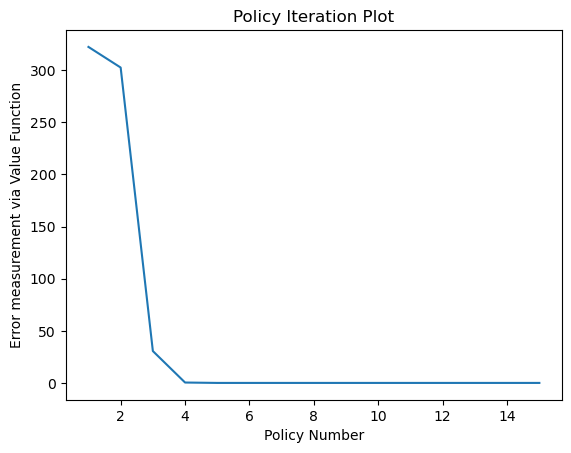

In [4]:
env.optimal_Policy()

#### Optimal Policy

In [5]:
env.get_Policy()

0 0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 
1 0 0 -1 -1 -2 -2 -3 -3 -4 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 
1 1 0 0 -1 -1 -2 -2 -3 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 
2 1 1 0 0 -1 -1 -2 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 
2 2 1 1 0 0 -1 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 
3 2 2 1 1 0 0 0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 
3 3 2 2 1 1 1 0 0 -1 -1 -2 -2 -3 -3 -4 -5 -5 -5 -5 -5 
4 3 3 2 2 2 1 1 0 0 -1 -1 -2 -2 -3 -4 -4 -5 -5 -5 -5 
4 4 3 3 3 2 2 1 1 0 0 -1 -1 -2 -3 -3 -4 -4 -4 -5 -5 
5 4 4 4 3 3 2 2 1 1 0 0 -1 -2 -2 -3 -3 -3 -4 -4 -4 
5 5 5 4 4 3 3 2 2 1 1 0 -1 -1 -2 -2 -2 -3 -3 -3 -4 
5 5 5 5 4 4 3 3 2 2 1 0 0 -1 -1 -1 -2 -2 -2 -3 -3 
5 5 5 5 5 4 4 3 3 2 1 1 0 0 0 -1 -1 -1 -2 -2 -3 
5 5 5 5 5 5 4 4 3 2 2 1 1 1 0 0 0 -1 -1 -2 -2 
5 5 5 5 5 5 5 4 3 3 2 2 2 1 1 1 0 0 -1 -1 -2 
5 5 5 5 5 5 5 4 4 3 3 3 2 2 2 1 1 0 0 -1 -2 
5 5 5 5 5 5 5 5 4 4 4 3 3 3 2 2 1 1 0 -1 -1 
5 5 5 5 5 5 5 5 5 5 4 4 4 3 3 2 2 1 0 0 -1 
5 5 5 5 5 5 5 5 5 5 5 5 4 4 3 3 2 1 1 0 0 
5 5 5 5 

<br> <br>
### Modifying Problem Statement
Transporting a car from one location to other costs $\$2$. Jack has a primary parking lot at both locations that can store at most 10 cars. If this parking lot gets filled, he needs to keep the additional cars at another parking lot that additionally charges $\$4$ per car. On a bright side, one of Jack's employee working at store 1 lives near store 2 and can transport one car to store 2 for free.

#### Updated Reward Function
$r(s_1, s_2, a) = 10x_1 + 10y_1 - 2(a-1) - 4 \times (a - max(10 - s_2, 0)) \quad if \ a > 0$

$r(s_1, s_2, a) = 10x_1 + 10y_1 - 2a - 4 \times (a - max(10 - s_2, 0)) \quad \quad \quad \ \ if \ a < 0$

### Code

#### Creating Environment

In [11]:
class Environment2:
    #Initialisation
    def __init__(self, gamma = 0.9):
        self.n = 20                                       #Number of non-terminal States
        self.m = 11                                       #Number of Actions
        self.half_m = int((self.m - 1) / 2)
        self.S1 = np.array(range(self.n+1))               #State Space for shop 1
        self.S2 = np.array(range(self.n+1))               #State Space for shop 2
        self.A = np.array(range(self.m))                  #Action space (Number of cars moved from shop 1 to 2)
        self.V = np.zeros((self.n+1, self.n+1))           #Value Function
        self.q = np.zeros((self.n+1, self.n+1, self.m))   #Action Value Function
        self.Policy = np.zeros((self.n+1, self.n+1), dtype=int)  #Policy
        self.gamma = gamma                                #Discount Factor
        self.lambda1_rent = 3                             #Mean number of cars rented from shop 1
        self.lambda1_ret  = 3                             #Mean number of cars returned to shop 1
        self.lambda2_rent = 4                             #Mean number of cars rented from shop 2
        self.lambda2_ret  = 2                             #Mean number of cars returned to shop 2
        self.prob = np.zeros((self.n+1, self.n+1, self.n+1, self.n+1))  #Probability of next state from current state and action
        
        self.calc_prob()
    
    #Reward Function
    def reward (self, s1, s2, a, x1, y1):
        if (a > 0):
            return 10*x1 + 10*y1 - 2*(a-1) - 4*(a - max(self.n/2 - s2, 0))
        else:
            return 10*x1 + 10*y1 - 2*a - 4*(a - max(self.n/2 - s2, 0))

    #Storing Probability
    def calc_prob (self):
        px1 = 0
        px2 = 0
        py1 = 0
        py2 = 0
        for x1 in range(self.n + 1):
            for x2 in range(self.n + 1):
                for y1 in range(self.n + 1):
                    for y2 in range(self.n + 1):
                        if (x1 < self.n):
                            px1 = poisson.pmf(x1, self.lambda1_rent)
                        else:
                            px1 = 1 - poisson.cdf(self.n - 1, self.lambda1_rent)

                        if (x2 < self.n):
                            px2 = poisson.pmf(x2, self.lambda1_ret)
                        else:
                            px2 = 1 - poisson.cdf(self.n - 1, self.lambda1_ret)

                        if (y1 < self.n):
                            py1 = poisson.pmf(y1, self.lambda2_rent)
                        else:
                            py1 = 1 - poisson.cdf(self.n - 1, self.lambda2_rent)

                        if (y2 < self.n):
                            py2 = poisson.pmf(y2, self.lambda2_ret)
                        else:
                            py2 = 1 - poisson.cdf(self.n - 1, self.lambda2_ret)
                        
                        self.prob[x1,x2,y1,y2] = px1 * px2 * py1 * py2
    
    #Calculating Value Function for 1 Iteration
    def calc_Value (self):
        for s1 in self.S1:
            for s2 in self.S2:
                v = 0
                a = self.Policy[s1,s2]
                for x1 in range((s1 - a) + 1):
                    for x2 in range(self.n - (s1 - a - x1) + 1):
                        for y1 in range((s2 + a) + 1):
                            for y2 in range(self.n - (s2 + a - y1) + 1):
                                r = self.reward(s1, s2, a, x1, y1)
                                next_s1 = s1 - a - x1 + x2
                                next_s2 = s2 + a - y1 + y2
                                v += self.prob[x1,x2,y1,y2] * (r + self.gamma * self.V[next_s1, next_s2])
                self.V[s1,s2] = v

    #Updating Value Function for current Policy
    def update_Value (self):
        tolerance = 10 ** 4
        err = 0
        while(True):
            old_V = self.V.copy()
            self.calc_Value()
            err = np.max(abs(self.V - old_V))
            if (err < tolerance):
                return

    #Updating Action-Value Function for current Policy
    def update_Q (self):
        for s1 in self.S1:
            for s2 in self.S2:
                for a in range(int(-1*self.half_m), self.half_m + 1):
                    if ((a > 0 and a > s1) or (a > 0 and s2 + a > self.n) or (a < 0 and abs(a) > s2) or (a < 0 and s1 - a > self.n)):
                        self.q[s1,s2,a + self.half_m] = 0
                        continue
                    q_temp = 0
                    for x1 in range((s1 - a) + 1):
                        for x2 in range(self.n - (s1 - a - x1) + 1):
                            for y1 in range((s2 + a) + 1):
                                for y2 in range(self.n - (s2 + a - y1) + 1):
                                    r = self.reward(s1, s2, a, x1, y1)
                                    next_s1 = s1 - a - x1 + x2
                                    next_s2 = s2 + a - y1 + y2
                                    q_temp += self.prob[x1,x2,y1,y2] * (r + self.gamma * self.V[next_s1, next_s2])
                    self.q[s1, s2, a + self.half_m] = q_temp
    
    #Finding Optimal Policy via Policy Iteration
    def optimal_Policy (self):
        start_time = time.time()
        tolerance = 10 ** -6
        err_array = []
        itr_array = []
        err = 0
        i = 0
        while(True):
            old_V = self.V.copy()
            self.update_Value()
            self.update_Q()
            self.Policy = np.argmax(self.q, axis = 2) - self.half_m
            err = np.max(abs(self.V - old_V))
            i += 1
            err_array.append(err)
            itr_array.append(i)
            print("Iteration Number: ", i, " | Error: ", err)
            if (err < tolerance):
                end_time = time.time()
                print("\nTotal Time Taken: ", int((end_time - start_time)/60), " min")
                self.plotError(itr_array, err_array)
                return
            

    #Print Value Function
    def get_Value (self):
        for s1 in self.S1:
            for s2 in self.S2:
                print(f"{self.V[s1,s2]: .2f}", end=" ")
            print(" ")
        
    #Print Policy
    def get_Policy (self):
        for s1 in self.S1:
            for s2 in self.S2:
                print(f"{self.Policy[s1,s2]: 1d}", end=" ")
            print("")

    #Plot Policy Iteration Error
    def plotError (self, x, y):
        plt.plot(x, y)
        plt.title("Policy Iteration Plot")
        plt.xlabel("Policy Number")
        plt.ylabel("Error measurement via Value Function")

In [12]:
env2 = Environment2()

#### Optimal Policy

Iteration Number:  1  | Error:  130.31918834934237
Iteration Number:  2  | Error:  236.94540736242016
Iteration Number:  3  | Error:  102.14435637196149
Iteration Number:  4  | Error:  74.26225455880905
Iteration Number:  5  | Error:  43.354212432597706
Iteration Number:  6  | Error:  30.794787009396373
Iteration Number:  7  | Error:  18.08655484109289
Iteration Number:  8  | Error:  10.645642530922089
Iteration Number:  9  | Error:  6.4633719325493075
Iteration Number:  10  | Error:  3.6024337650472944
Iteration Number:  11  | Error:  1.9828007908078007
Iteration Number:  12  | Error:  1.080215064376432
Iteration Number:  13  | Error:  0.5856790452623386
Iteration Number:  14  | Error:  0.317451317898076
Iteration Number:  15  | Error:  0.17133991330695153
Iteration Number:  16  | Error:  0.09235243308489771
Iteration Number:  17  | Error:  0.04974976878401094
Iteration Number:  18  | Error:  0.02679109902419441
Iteration Number:  19  | Error:  0.014424245246402734
Iteration Number:  

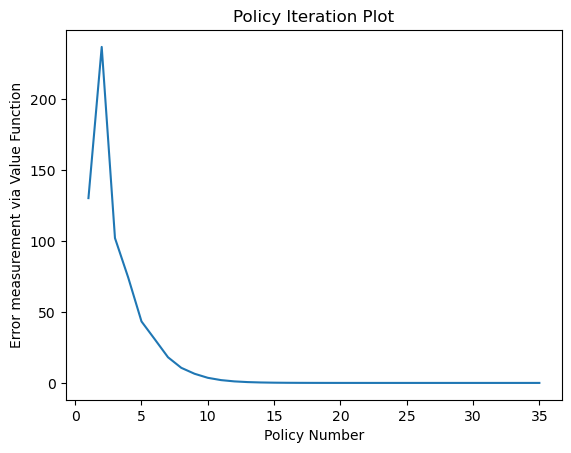

In [13]:
env2.optimal_Policy()

In [14]:
env2.get_Policy()

 0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 
 1  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 
 1  1  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 
 2  1  1  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 2  2  1  1  0  0 -1 -1 -2 -2 -3 -3 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 3  2  2  1  1  0  0 -1 -1 -2 -2 -3 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 3  3  2  2  1  1  0  0 -1 -1 -2 -3 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 4  3  3  2  2  1  1  0  0 -1 -2 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 
 4  4  3  3  2  2  1  1  0 -1 -2 -3 -3 -4 -5 -5 -5 -5 -5 -5 -5 
 5  4  4  3  3  2  2  1  1 -1 -2 -2 -3 -4 -5 -5 -5 -5 -5 -5 -5 
 5  5  4  4  3  3  2  1  1 -1 -1 -2 -3 -4 -4 -4 -4 -4 -4 -4 -4 
 5  5  5  4  4  3  2  1  1 -1 -1 -2 -3 -3 -3 -3 -3 -3 -3 -3 -4 
 5  5  5  5  4  3  2  1  1  0 -1 -2 -2 -2 -2 -2 -2 -2 -2 -3 -3 
 5  5  5  5  4  3  2  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -2 -2 -3 
 5  5  5  5  4  3  2  2  1  1  1  1  1  1  1  1  0 -1 -1 -2 -2 
 5  5  5  5  4  3  3  2  1  1  1  1  1  

<br><br>
### Obtaining Results Using Value Iteration

In [19]:
class Environment3:
    #Initialisation
    def __init__(self, gamma = 0.9):
        self.n = 20                                       #Number of non-terminal States
        self.m = 11                                       #Number of Actions
        self.half_m = int((self.m - 1) / 2)
        self.S1 = np.array(range(self.n+1))               #State Space for shop 1
        self.S2 = np.array(range(self.n+1))               #State Space for shop 2
        self.A = np.array(range(self.m))                  #Action space (Number of cars moved from shop 1 to 2)
        self.V = np.zeros((self.n+1, self.n+1))           #Value Function
        self.q = np.zeros((self.n+1, self.n+1, self.m))   #Action Value Function
        self.Policy = np.zeros((self.n+1, self.n+1), dtype=int)  #Policy
        self.gamma = gamma                                #Discount Factor
        self.lambda1_rent = 3                             #Mean number of cars rented from shop 1
        self.lambda1_ret  = 3                             #Mean number of cars returned to shop 1
        self.lambda2_rent = 4                             #Mean number of cars rented from shop 2
        self.lambda2_ret  = 2                             #Mean number of cars returned to shop 2
        self.prob = np.zeros((self.n+1, self.n+1, self.n+1, self.n+1))  #Probability of next state from current state and action
        
        self.calc_prob()
    
    #Reward Function
    def reward (self, s1, s2, a, x1, y1):
        if (a > 0):
            return 10*x1 + 10*y1 - 2*(a-1) - 4*(a - max(self.n/2 - s2, 0))
        else:
            return 10*x1 + 10*y1 - 2*a - 4*(a - max(self.n/2 - s2, 0))

    #Storing Probability
    def calc_prob (self):
        px1 = 0
        px2 = 0
        py1 = 0
        py2 = 0
        for x1 in range(self.n + 1):
            for x2 in range(self.n + 1):
                for y1 in range(self.n + 1):
                    for y2 in range(self.n + 1):
                        if (x1 < self.n):
                            px1 = poisson.pmf(x1, self.lambda1_rent)
                        else:
                            px1 = 1 - poisson.cdf(self.n - 1, self.lambda1_rent)

                        if (x2 < self.n):
                            px2 = poisson.pmf(x2, self.lambda1_ret)
                        else:
                            px2 = 1 - poisson.cdf(self.n - 1, self.lambda1_ret)

                        if (y1 < self.n):
                            py1 = poisson.pmf(y1, self.lambda2_rent)
                        else:
                            py1 = 1 - poisson.cdf(self.n - 1, self.lambda2_rent)

                        if (y2 < self.n):
                            py2 = poisson.pmf(y2, self.lambda2_ret)
                        else:
                            py2 = 1 - poisson.cdf(self.n - 1, self.lambda2_ret)
                        
                        self.prob[x1,x2,y1,y2] = px1 * px2 * py1 * py2
    
    #Calculating Value Function for 1 Iteration
    def calc_Value (self):
        for s1 in self.S1:
            for s2 in self.S2:
                v = 0
                a = self.Policy[s1,s2]
                for x1 in range((s1 - a) + 1):
                    for x2 in range(self.n - (s1 - a - x1) + 1):
                        for y1 in range((s2 + a) + 1):
                            for y2 in range(self.n - (s2 + a - y1) + 1):
                                r = self.reward(s1, s2, a, x1, y1)
                                next_s1 = s1 - a - x1 + x2
                                next_s2 = s2 + a - y1 + y2
                                v += self.prob[x1,x2,y1,y2] * (r + self.gamma * self.V[next_s1, next_s2])
                self.V[s1,s2] = v

    #Updating Value Function for current Policy
    def update_Value (self):
        tolerance = 10 ** 4
        err = 0
        while(True):
            old_V = self.V.copy()
            self.calc_Value()
            err = np.max(abs(self.V - old_V))
            if (err < tolerance):
                return

    #Updating Action-Value Function for current Policy
    def update_Q (self):
        for s1 in self.S1:
            for s2 in self.S2:
                for a in range(int(-1*self.half_m), self.half_m + 1):
                    if ((a > 0 and a > s1) or (a > 0 and s2 + a > self.n) or (a < 0 and abs(a) > s2) or (a < 0 and s1 - a > self.n)):
                        self.q[s1,s2,a + self.half_m] = 0
                        continue
                    q_temp = 0
                    for x1 in range((s1 - a) + 1):
                        for x2 in range(self.n - (s1 - a - x1) + 1):
                            for y1 in range((s2 + a) + 1):
                                for y2 in range(self.n - (s2 + a - y1) + 1):
                                    r = self.reward(s1, s2, a, x1, y1)
                                    next_s1 = s1 - a - x1 + x2
                                    next_s2 = s2 + a - y1 + y2
                                    q_temp += self.prob[x1,x2,y1,y2] * (r + self.gamma * self.V[next_s1, next_s2])
                    self.q[s1, s2, a + self.half_m] = q_temp
    
    #Finding Optimal Policy via Policy Iteration
    def optimal_Policy (self):
        start_time = time.time()
        tolerance = 10 ** -6
        err_array = []
        itr_array = []
        err = 0
        i = 0
        while(True):
            old_V = self.V.copy()
            self.update_Value()
            self.update_Q()
            self.Policy = np.argmax(self.q, axis = 2) - self.half_m
            err = np.max(abs(self.V - old_V))
            i += 1
            err_array.append(err)
            itr_array.append(i)
            print("Iteration Number: ", i, " | Error: ", err)
            if (err < tolerance):
                end_time = time.time()
                print("\nTotal Time Taken: ", int((end_time - start_time)/60), " min")
                self.plotError(itr_array, err_array)
                return

    def value_iteration (self):
        start_time = time.time()
        tolerance = 10 ** -6
        err_array = []
        itr_array = []
        err = 0
        i = 0
        while(True):
            old_V = self.V.copy()
            self.calc_Value()
            self.update_Q()
            self.Policy = np.argmax(self.q, axis = 2) - self.half_m
            err = np.max(abs(self.V - old_V))
            i += 1
            err_array.append(err)
            itr_array.append(i)
            print("Iteration Number: ", i, " | Error: ", err)
            if (err < tolerance):
                end_time = time.time()
                print("\nTotal Time Taken: ", int((end_time - start_time)/60), " min")
                self.plotError(itr_array, err_array)
                return

    #Print Value Function
    def get_Value (self):
        for s1 in self.S1:
            for s2 in self.S2:
                print(f"{self.V[s1,s2]: .2f}", end=" ")
            print(" ")
        
    #Print Policy
    def get_Policy (self):
        for s1 in self.S1:
            for s2 in self.S2:
                print(f"{self.Policy[s1,s2]: 1d}", end=" ")
            print("")

    #Plot Policy Iteration Error
    def plotError (self, x, y):
        plt.plot(x, y)
        plt.title("Policy Iteration Plot")
        plt.xlabel("Policy Number")
        plt.ylabel("Error measurement via Value Function")

In [20]:
env3 = Environment3()

Iteration Number:  1  | Error:  130.31918834934237
Iteration Number:  2  | Error:  236.94540736242016
Iteration Number:  3  | Error:  102.14435637196149
Iteration Number:  4  | Error:  74.26225455880905
Iteration Number:  5  | Error:  43.354212432597706
Iteration Number:  6  | Error:  30.794787009396373
Iteration Number:  7  | Error:  18.08655484109289
Iteration Number:  8  | Error:  10.645642530922089
Iteration Number:  9  | Error:  6.4633719325493075
Iteration Number:  10  | Error:  3.6024337650472944
Iteration Number:  11  | Error:  1.9828007908078007
Iteration Number:  12  | Error:  1.080215064376432
Iteration Number:  13  | Error:  0.5856790452623386
Iteration Number:  14  | Error:  0.317451317898076
Iteration Number:  15  | Error:  0.17133991330695153
Iteration Number:  16  | Error:  0.09235243308489771
Iteration Number:  17  | Error:  0.04974976878401094
Iteration Number:  18  | Error:  0.02679109902419441
Iteration Number:  19  | Error:  0.014424245246402734
Iteration Number:  

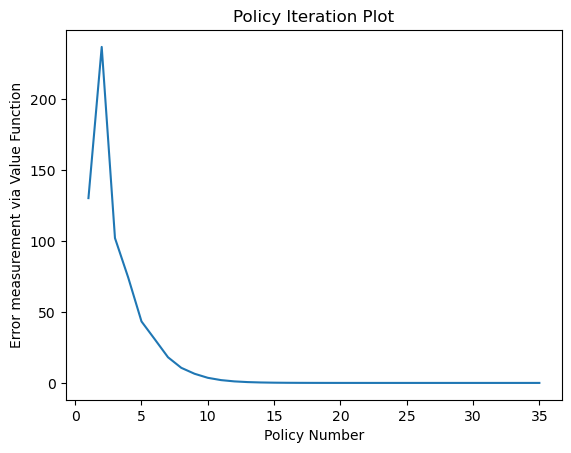

In [21]:
env3.value_iteration()

In [22]:
env3.get_Policy()

 0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 
 1  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 
 1  1  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 
 2  1  1  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 2  2  1  1  0  0 -1 -1 -2 -2 -3 -3 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 3  2  2  1  1  0  0 -1 -1 -2 -2 -3 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 3  3  2  2  1  1  0  0 -1 -1 -2 -3 -4 -5 -5 -5 -5 -5 -5 -5 -5 
 4  3  3  2  2  1  1  0  0 -1 -2 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 
 4  4  3  3  2  2  1  1  0 -1 -2 -3 -3 -4 -5 -5 -5 -5 -5 -5 -5 
 5  4  4  3  3  2  2  1  1 -1 -2 -2 -3 -4 -5 -5 -5 -5 -5 -5 -5 
 5  5  4  4  3  3  2  1  1 -1 -1 -2 -3 -4 -4 -4 -4 -4 -4 -4 -4 
 5  5  5  4  4  3  2  1  1 -1 -1 -2 -3 -3 -3 -3 -3 -3 -3 -3 -4 
 5  5  5  5  4  3  2  1  1  0 -1 -2 -2 -2 -2 -2 -2 -2 -2 -3 -3 
 5  5  5  5  4  3  2  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -2 -2 -3 
 5  5  5  5  4  3  2  2  1  1  1  1  1  1  1  1  0 -1 -1 -2 -2 
 5  5  5  5  4  3  3  2  1  1  1  1  1  